# Figure 10
Variation in INP concentration and active site density with altitude. Also contained in this are calcualtions of the drop-off factor used in Table 2 of the paper.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.text as mtext
import pandas as pd
import numpy as np
import faamasd as asd
from glob import glob
import os
import xarray as xr

In [2]:
param = pd.read_csv('/home/users/erinraif/acao_data/metadata/parametrisations_v6_three_param.csv',
                   index_col = 'unique_ID')

In [3]:
INP_concentrations = pd.read_csv('/home/users/erinraif/acao_data/inp_data/subtracted_backgrounds_v4_2ul.csv', index_col='temp_bin')
renamed_columns = [col.replace('err', 'NT_err') for col in INP_concentrations.columns]
INP_concentrations.columns = renamed_columns
nX_data = pd.read_csv('/home/users/erinraif/acao_data/inp_data/nX_calibrated_v3.csv',index_col='temp_bin')

In [4]:
all_data = pd.merge(INP_concentrations,nX_data,left_index=True,right_index=True)

In [5]:
metadata = pd.read_csv('/home/users/erinraif/acao_data/metadata/filters_reduced_metadata.csv',
                      index_col='unique_ID')
#param = pd.merge(param, metadata, left_index=True, right_index=True)

In [6]:
metadata = metadata.drop(['c276r3t','c278r3t'])

In [7]:
all_data['c271r1t_nS'] = pd.Series([np.nan]*len(all_data), index=all_data.index)
all_data['c271r2t_nS'] = pd.Series([np.nan]*len(all_data), index=all_data.index)
all_data['c271r3t_nS'] = pd.Series([np.nan]*len(all_data), index=all_data.index)
all_data['c272r6t_nS'] = pd.Series([np.nan]*len(all_data), index=all_data.index)

In [8]:
NT_name = metadata.index.str[:] + '_NT'
nS_name = metadata.index.str[:] + '_nS'

# Find the corresponding value in param for index -15
inp_values = all_data.loc[-15, NT_name]
nS_values = all_data.loc[-15, nS_name]

inp_values.index = inp_values.index.str[:-3]
nS_values.index = nS_values.index.str[:-3]

metadata['INP_at_15'] = inp_values
metadata['nS_at_15'] = nS_values

In [9]:
class LegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mtext.Text(x0, y0, orig_handle, **self.text_props)
        handlebox.add_artist(title)
        return title

def add_subtitles(color_exs, ax):
    handles, labels = ax.get_legend_handles_labels()
    handles.insert(0, 'Flight')
    labels.insert(0, '')
    
    handles.insert(len(color_exs)+1, 'Sample type')
    labels.insert(len(color_exs)+1, '')
    
    legend = ax.legend(handles, labels, handler_map={str: LegendTitle({'fontsize': 15})},
                      loc='upper left', bbox_to_anchor=(1, 1.05), fontsize=14)
    return legend

/tmp/ipykernel_10063/2039727267.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  for flight_id, color in zip(flight_ids, plt.cm.get_cmap('tab10').colors):


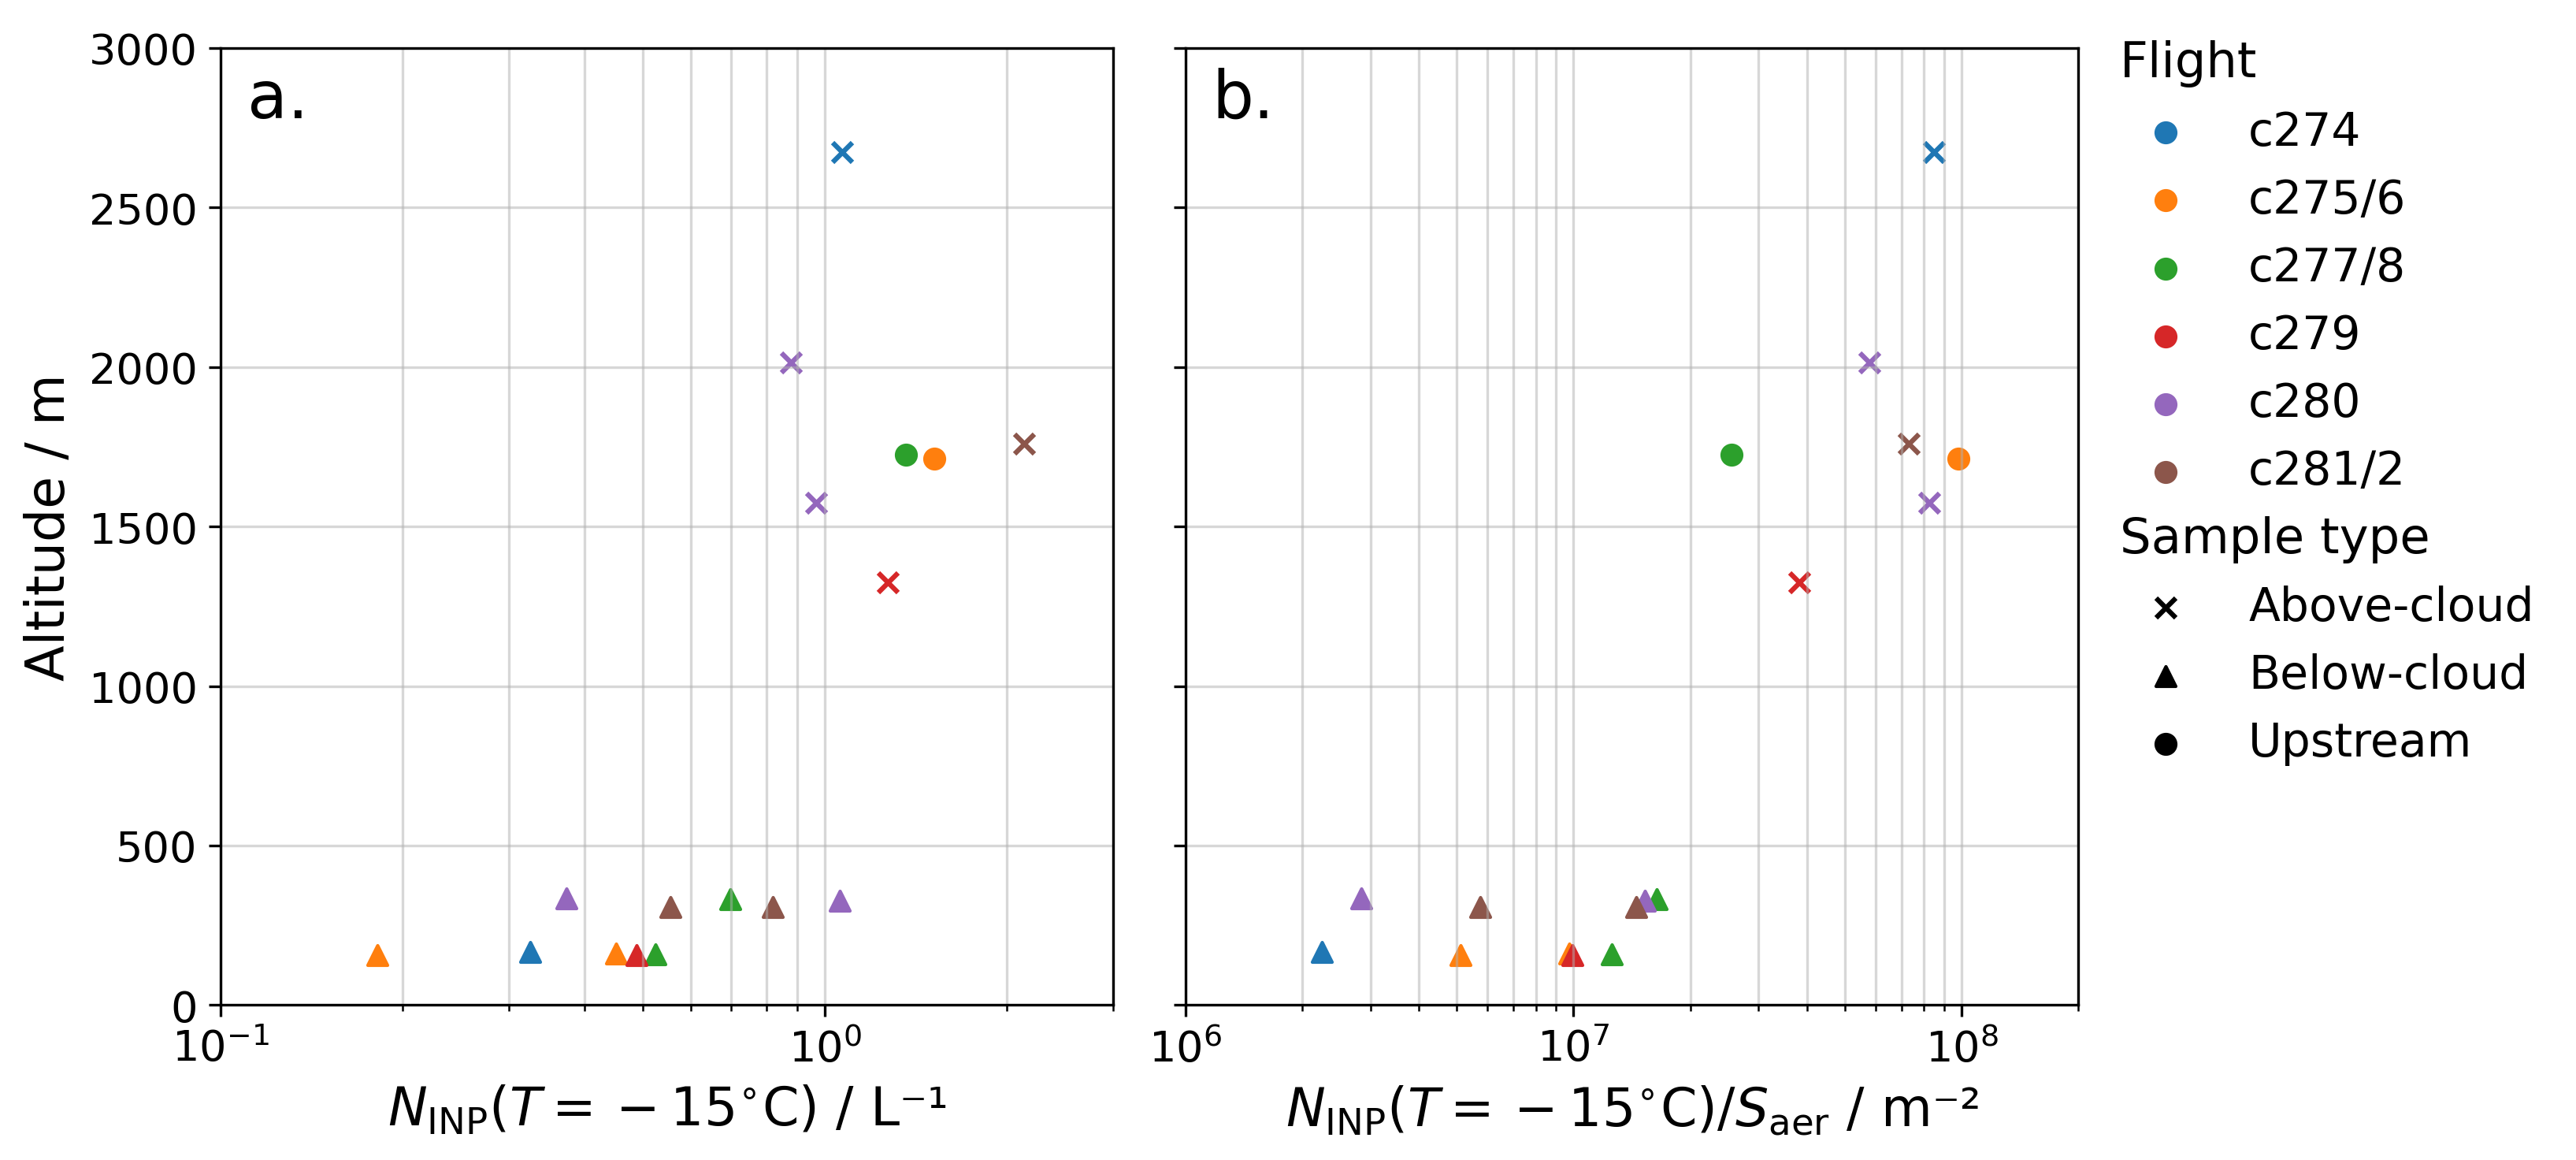

In [38]:
type_marker_mapping = {
    'above': ('x', 'Above-cloud'),
    'below': ('^', 'Below-cloud'),
    'upstream': ('o', 'Upstream'),
}

# Create a list of unique flight IDs for coloring
flight_ids = metadata['flight_id'].unique()
flight_ids = flight_ids[3:] # select flightids from c274 onwards only (as these are northerly)

# Create subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,5),dpi=300, sharey=True)

ax1.set_xscale('log')
ax1.set_xlim(0.1, 3)
ax2.set_xscale('log')
ax2.set_xlim(1e6, 2e8)

color_exs = []
marker_exs = []

for ax in (ax1, ax2):
    ax.set_ylim(0,3000)
    ax.tick_params(axis='both', which='both', labelsize=13)
    ax.grid(which='major')
    ax.grid(which='both',alpha=0.5)

# Loop over flights and run-types so to get correct symbols.
for flight_id, color in zip(flight_ids, plt.cm.get_cmap('tab10').colors):
    subset = metadata[(metadata['flight_id'] == flight_id)]
    for type_value, marker in type_marker_mapping.items():
        subset2 = subset[subset['type'] == type_value]
        ax1.scatter(subset2['INP_at_15'], subset2['probe_alt'], c=[color], marker=marker[0])
        ax2.scatter(subset2['nS_at_15'], subset2['probe_alt'], c=[color], marker=marker[0])
    color_exs.append(ax2.scatter(-100, -100, c=[color], marker='o', label=flight_id))
    
for type_value, marker in type_marker_mapping.items():
    marker_exs.append(ax2.scatter(-100, -100, c=['k'], marker=marker[0], label=marker[1]))

ax1.set_xlabel(r'$N_{\mathrm{INP}}(T=-15^{\circ}\mathrm{C})$ / L⁻¹', fontsize=16)
ax2.set_xlabel(r'$N_{\mathrm{INP}}(T=-15^{\circ}\mathrm{C})/S_{\mathrm{aer}}$ / m⁻²', fontsize=16)
ax1.set_ylabel('Altitude / m',fontsize=16)
legend = add_subtitles(color_exs, ax2)
legend.set_frame_on(False)

ax1.text(0.03, 0.98, 'a.', ha='left', va='top', fontsize=20,
           transform=ax1.transAxes)
ax2.text(0.03, 0.98, 'b.', ha='left', va='top', fontsize=20,
           transform=ax2.transAxes)

# Adjust the layout to make room for the legend
plt.subplots_adjust(right=0.95) 

fig.tight_layout()
fig.savefig('./imgs/f10.pdf')

# Calculation of ratios of INP concentration and nS up/downstream.
Bit messy, apologies!

In [24]:
above_cloud_northerlies = metadata[(metadata['altitude'] >= 3000) & (metadata['flight_id'] >= 'c274')]
below_cloud_northerlies = metadata[(metadata['altitude'] < 3000) & (metadata['flight_id'] >= 'c274')]

In [33]:
# note altitude here refers to feet. bloomin' aircraft...
above_cloud_mean_INP = above_cloud_northerlies['INP_at_15'].mean()
below_cloud_mean_INP = below_cloud_northerlies['INP_at_15'].mean()
"{:.3e} {:.3e}".format(above_cloud_mean_INP, below_cloud_mean_INP)
#print(above_cloud_mean_INP/below_cloud_mean_INP)

2.400238716183002


In [27]:
# note altitude here refers to feet. bloomin' aircraft...
above_cloud_std_INP = above_cloud_northerlies['INP_at_15'].std()
below_cloud_std_INP = below_cloud_northerlies['INP_at_15'].std()
"{:.3e} {:.3e}".format(above_cloud_std_INP, below_cloud_std_INP)

'4.262e-01 2.547e-01'

In [31]:
# note altitude here refers to feet. bloomin' aircraft...
above_cloud_uq_INP = above_cloud_northerlies['INP_at_15'].quantile(0.75)
below_cloud_uq_INP = below_cloud_northerlies['INP_at_15'].quantile(0.75)
above_cloud_lq_INP = above_cloud_northerlies['INP_at_15'].quantile(0.25)
below_cloud_lq_INP = below_cloud_northerlies['INP_at_15'].quantile(0.25)
"above uq {:.3e} lq {:.3e} iqr {:.3e} below uq {:.3e} lq {:.3e} iqr {:.3e}".format(
    above_cloud_uq_INP, above_cloud_lq_INP, above_cloud_uq_INP - above_cloud_lq_INP,
    below_cloud_uq_INP, below_cloud_lq_INP, below_cloud_uq_INP - below_cloud_lq_INP)

'above uq 1.438e+00 lq 1.018e+00 iqr 4.198e-01 below uq 6.612e-01 lq 3.926e-01 iqr 2.686e-01'

In [36]:
# note altitude here refers to feet. bloomin' aircraft...
above_cloud_mean_nS = metadata[(metadata['altitude'] >= 3000) & (metadata['flight_id'] >= 'c274')]['nS_at_15'].mean()
below_cloud_mean_nS = metadata[(metadata['altitude'] < 3000) & (metadata['flight_id'] >= 'c274')]['nS_at_15'].mean()
"{:.3e} {:.3e}".format(above_cloud_mean_nS, below_cloud_mean_nS)
print(above_cloud_mean_nS/below_cloud_mean_nS)

6.973929891513513


In [23]:
# note altitude here refers to feet. bloomin' aircraft...
above_cloud_std_nS = metadata[(metadata['altitude'] >= 3000) & (metadata['flight_id'] >= 'c274')]['nS_at_15'].std()
below_cloud_std_nS = metadata[(metadata['altitude'] < 3000) & (metadata['flight_id'] >= 'c274')]['nS_at_15'].std()
"{:.3e} {:.3e}".format(above_cloud_std_nS, below_cloud_mean_nS)

'2.641e+07 5.216e+06'

In [32]:
# note altitude here refers to feet. bloomin' aircraft...
above_cloud_uq_nS = above_cloud_northerlies['nS_at_15'].quantile(0.75)
below_cloud_uq_nS = below_cloud_northerlies['nS_at_15'].quantile(0.75)
above_cloud_lq_nS = above_cloud_northerlies['nS_at_15'].quantile(0.25)
below_cloud_lq_nS = below_cloud_northerlies['nS_at_15'].quantile(0.25)
"above uq {:.3e} lq {:.3e} iqr {:.3e} below uq {:.3e} lq {:.3e} iqr {:.3e}".format(
    above_cloud_uq_nS, above_cloud_lq_nS, above_cloud_uq_nS - above_cloud_lq_nS,
    below_cloud_uq_nS, below_cloud_lq_nS, below_cloud_uq_nS - below_cloud_lq_nS)

'above uq 8.375e+07 lq 4.801e+07 iqr 3.573e+07 below uq 1.399e+07 lq 5.272e+06 iqr 8.722e+06'

In [18]:
subset = metadata[metadata['type'] == 'below']
pr_sub = subset[['flight_id','nS_at_15','INP_at_15','mean_lat','altitude']]
pr_sub

,flight_id,nS_at_15,INP_at_15,mean_lat,altitude
unique_ID,,,,,
c271r2t,c271,NaN,0.492790,75.521200,100
c271r3t,c271,NaN,0.325043,72.665080,250
c273r2t,c273,4.030951e+05,0.029176,73.928200,1500
c274r3t,c274,2.249745e+06,0.325405,71.162280,500
c275r1t,c275/6,9.739628e+06,0.450914,76.521000,500
c276r4t,c275/6,5.116867e+06,0.181881,74.596340,500
c277r1t,c277/8,1.252944e+07,0.524764,76.719430,500
c278r4t,c277/8,1.637327e+07,0.696623,75.145170,1000
c279r1t,c279,9.948981e+06,0.487857,76.892170,500


In [21]:
# Hacky loop to look for one individual run. if statement takes little time as few datapoints,
# so copied from other notebooks
base = '/home/users/erinraif/acao_data/probe_calibration/'
pcasp_scattering_inputs = asd.pcasp_scattering_inputs
cdp_scattering_inputs = asd.cdp_scattering_inputs
cdp_channel_data_folder = base + 'channel_data_CDP'
pcasp_channel_data_folder = base + 'channel_data_PCASP'
attribute_file = base + 'attributes_for_calibration_arrays.txt' # Set to None if not present
pcasp_calibration = asd.produce_calibration_dataset(pcasp_channel_data_folder,pcasp_scattering_inputs,
                                                    attribute_file)
cdp_calibration = asd.produce_calibration_dataset(cdp_channel_data_folder,cdp_scattering_inputs,attribute_file)
pcasp_cal_at_ri = pcasp_calibration.sel(refractive_index = 1.56+0j)
cdp_cal_at_ri = cdp_calibration.sel(refractive_index = 1.56+0j)
timings_data = pd.read_csv(
    '/home/users/erinraif/acao_data/metadata/timings_of_filter_legs_acao.csv',
    index_col='unique_ID')
timings_data = timings_data[timings_data['psd_available'] == True]
timings_data = timings_data.drop(['c276r3t','c278r3t'])
leg_types = pd.read_csv('/home/users/erinraif/acao_data/metadata/filter_leg_types.csv',
                        index_col='unique_ID')
def get_timings(metadata_row):
    """Retrieve filter run timings, including pauses.
    
    Returns a list of consecutive times as ints in SPM. This is in the format
    [start, (pause1 start), (pause1 end), ..., end]
    where pauses are only present where necessary.
    
    Parameters
    ----------
    metadata_row: pandas Series
        row of the metadata pandas dataframe
    
    Returns
    -------
    list of ints
        times in SPM of run events
    """
    leg_start_times = [metadata_row.start_time]
    leg_end_times = [metadata_row.end_time]
    pauses = metadata_row.no_pauses
    for i in range(pauses):
        start_str = 'metadata_row.pause' + str(i+1) + '_end'
        end_str = 'metadata_row.pause' + str(i+1) + '_start'
        leg_start_times.append(eval(start_str))
        leg_end_times.insert(i, eval(end_str))
    return leg_start_times, leg_end_times

def get_dS_data_for_filter(filter_name):
    for run in timings_data.itertuples():
        if run.Index == filter_name:
        # Get the correct datasets for the run and and merge them 
            core_cloud_data_fn = glob(os.path.join(
                '/badc/faam/data/2022',run.flight + '*/core_processed',run.core_cloud
            ))[0]
            core_data_fn = glob(os.path.join(
                '/badc/faam/data/2022',run.flight + '*/core_processed',run.core_faam
            ))[0]
            nev_data_fn = '/home/users/erinraif/acao_data/nevzorov_data/' + run.nev_data
            flight_data = asd.get_data(core_cloud_data_fn, core_data_fn)
        
            # Make Nevzorov cloud-flag data compatible with other datasets
            nev_ds = xr.open_dataset(nev_data_fn, engine='netcdf4',decode_times=False)
            nev_ds = nev_ds.rename_dims({'TIME': 'time'})
            nev_ds = nev_ds.rename({'TIME': 'time'})
            nev_flag = nev_ds.CLRFLG_COMBINED
        
            # Get timings for each run and clip data appropriately
            leg_start_times, leg_end_times = get_timings(run)
            nev_flag = asd.time_slice_data(leg_start_times, leg_end_times, nev_flag)
            uncorrected_pcasp, corrected_pcasp, pcasp_flow = asd.get_pcasp_data_for_leg(flight_data, leg_start_times, leg_end_times)
            pcasp_psds = asd.get_mean_log_psds(pcasp_cal_at_ri, uncorrected_pcasp, corrected_pcasp, pcasp_flow)
            uncorrected_cdp, corrected_cdp, cdp_flow = asd.get_cdp_data_for_leg(flight_data, leg_start_times, leg_end_times)
            rh_liq = asd.time_slice_data(leg_start_times, leg_end_times, flight_data['RH_LIQ'])
            
            # Apply humidity mask and Nevzorov cloud-presence mask
            rh_mask = rh_liq < 80
            nev_mask = nev_flag > 0.5
            comb_mask = rh_mask & nev_mask
            comb_uncorrected_cdp = uncorrected_cdp.where(comb_mask,drop=True)
            comb_corrected_cdp = corrected_cdp.where(comb_mask, drop=True)
        
            # Get mean particle size distributions during each leg
            comb_cdp_psds = asd.get_mean_log_psds(cdp_cal_at_ri, comb_uncorrected_cdp, comb_corrected_cdp, cdp_flow)

            _, dS, _, _, dS_err, _ = asd.integrate_distribution_with_errors_over_time(pcasp_psds, comb_cdp_psds)
    return dS.values, dS_err.values

In [19]:
def drop_off(upstream, downstream, subset):
    INP_factor_7576 = subset.loc[upstream]['INP_at_15']/subset.loc[downstream]['INP_at_15']
    nS_factor_7576 = subset.loc[upstream]['nS_at_15']/subset.loc[downstream]['nS_at_15']
    lat_drop_7576 = subset.loc[upstream]['mean_lat']-subset.loc[downstream]['mean_lat']
    this_flight_id = subset.loc[upstream]['flight_id']
    dS_up, _ = get_dS_data_for_filter(upstream)
    dS_down, _ = get_dS_data_for_filter(downstream)
    dS_factor = dS_up/dS_down
    print(f'Flight {this_flight_id}')
    print(f'Over {lat_drop_7576:.2f} degrees of latitude, the INP concentration decreased by a factor of' +
         f' {INP_factor_7576:.2f} while the the active site density decreased by a factor of {nS_factor_7576:.2f}' +
         f' and the total aerosol surface area decreased by {dS_factor:.2f}')
    return None

In [22]:
drop_off('c275r1t','c276r4t', pr_sub)
#drop_off('c277r1t','c278r4t', pr_sub) not included due to runs not being connected airmasses
drop_off('c280r2t','c280r4t', pr_sub)
drop_off('c282r2t','c282r3t', pr_sub)

Flight c275/6
Over 1.92 degrees of latitude, the INP concentration decreased by a factor of 2.48 while the the active site density decreased by a factor of 1.90 and the total aerosol surface area decreased by 1.33
Flight c277/8
Over 1.57 degrees of latitude, the INP concentration decreased by a factor of 0.75 while the the active site density decreased by a factor of 0.77 and the total aerosol surface area decreased by 1.01
Flight c280
Over 2.17 degrees of latitude, the INP concentration decreased by a factor of 2.84 while the the active site density decreased by a factor of 5.38 and the total aerosol surface area decreased by 0.54
Flight c281/2
Over 3.58 degrees of latitude, the INP concentration decreased by a factor of 1.48 while the the active site density decreased by a factor of 2.52 and the total aerosol surface area decreased by 0.59
